<a href="https://colab.research.google.com/github/Pompey21/Don-t-Let-the-Bark-Beetle-Bite-You/blob/main/infected_region_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
######## INSTALATION
!pip install sentinelhub
!pip install s2cloudless
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import files
from PIL import Image
import datetime as dt
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, \
    MimeType, bbox_to_dimensions
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest, get_s2_evalscript

In [46]:
"""
Plotting utilities for example notebooks
"""
import matplotlib.pyplot as plt
import numpy as np


def plot_image(image=None, mask=None, ax=None, factor=3.5/255, clip_range=(0, 1), **kwargs):
    """ Utility function for plotting RGB images and masks.
    """
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

    mask_color = [255, 255, 255, 255] if image is None else [255, 255, 0, 100]

    if image is None:
        if mask is None:
            raise ValueError('image or mask should be given')
        image = np.zeros(mask.shape + (3,), dtype=np.uint8)

    ax.imshow(np.clip(image * factor, *clip_range), **kwargs)

    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

        cloud_image[mask == 1] = np.asarray(mask_color, dtype=np.uint8)

        ax.imshow(cloud_image)


def plot_probabilities(image, proba, factor=3.5/255):
    """ Utility function for plotting a RGB image and its cloud probability map next to each other.
    """
    plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(np.clip(image * factor, 0, 1))
    ax = plt.subplot(1, 2, 2)
    ax.imshow(proba, cmap=plt.cm.inferno)

def plot_ndvi(ndvi_image):
    plt.figure(figsize=(15, 15))
    sns.diverging_palette(60, 160, as_cmap=True)
    ax = sns.heatmap(ndvi_image)

    plt.title("Normalised Vegetation Index",fontsize=12)

    plt.savefig("NDVI_1.png", bbox_inches='tight', dpi=100)

    plt.show()

In [47]:
# setting configuration information to access data from the ScienceHub
def is_config():
  config = SHConfig()

  config.instance_id = 'c7b45463-8ad6-483e-b775-b1a561cca401'
  config.sh_client_id = '766f8ea6-160f-4351-ad48-06058abbd590'
  config.sh_client_secret = 'z^{3w^zz%lrq^;rf-7T:Anu!@[8pJ]_O<*2-NRn9'

  config.save()

  # In case you put the credentials into the configuration file you can leave this unchanged
  CLIENT_ID = ''
  CLIENT_SECRET = ''

  config = SHConfig()

  if CLIENT_ID and CLIENT_SECRET:
      config.sh_client_id = CLIENT_ID
      config.sh_client_secret = CLIENT_SECRET
  return config

In [48]:
# coordinates of the region
# bbox = BBox([14.569134840593051,45.59918397980536,14.590077528581332,45.612334146131815], crs=CRS.WGS84)

In [49]:
def get_RGB_bands_data(date:str,bbox:BBox,config): 
  evalscript_true_color = """
      //VERSION=3

      function setup() {
          return {
              input: [{
                  bands: ["B02", "B03", "B04"]
              }],
              output: {
                  bands: 3
              }
          };
      }

      function evaluatePixel(sample) {
          return [sample.B04, sample.B03, sample.B02];
      }
  """

  request = SentinelHubRequest(
      evalscript=evalscript_true_color,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L1C,
              time_interval=date
          )
      ],
      responses=[
          SentinelHubRequest.output_response('default', MimeType.PNG)
      ],
      bbox=bbox,
      size=bbox_to_dimensions(bbox, 10),
      config=config
  )

  true_color_image = request.get_data()[0]

  true_color_image.shape
  return true_color_image

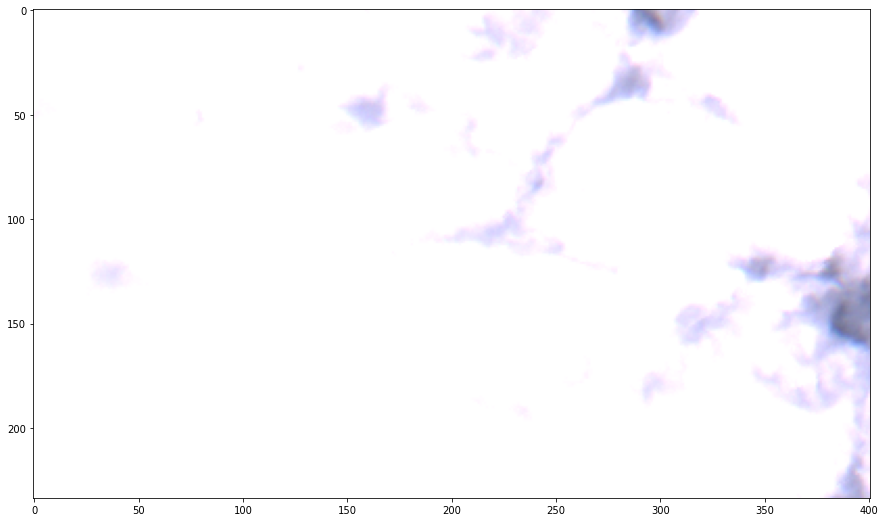

In [162]:
date = ('2019-01-01','2019-12-31')
bbox = BBox([14.231442824859885,45.77008157282224,
14.28276957656887,45.791511016125
], crs=CRS.WGS84)
config = is_config()
true_color_image = get_RGB_bands_data(date,bbox,config)
plot_image(true_color_image)

In [51]:
def get_all_bands_data(date:str,bbox:BBox,config):  
  evalscript_all_bands = """
      //VERSION=3
      function setup() {
          return {
              input: [{
                  bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                  units: "DN"
              }],
              output: {
                  bands: 13,
                  sampleType: "INT16"
              }
          };
      }

      function evaluatePixel(sample) {
          return [sample.B01,
                  sample.B02,
                  sample.B03,
                  sample.B04,
                  sample.B05,
                  sample.B06,
                  sample.B07,
                  sample.B08,
                  sample.B8A,
                  sample.B09,
                  sample.B10,
                  sample.B11,
                  sample.B12];
      }
  """

  request_all_bands = SentinelHubRequest(
      evalscript=evalscript_all_bands,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L1C,
              time_interval=date,
              mosaicking_order="leastCC",
          )
      ],
      responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
      bbox=bbox,
      size=bbox_to_dimensions(bbox, 10),
      config=config,
  )

  all_bands_response = request_all_bands.get_data()
  plot_image(all_bands_response[0][:, :, 1:4], factor=3.5 / 1e4, vmax=1)

  return request_all_bands

  request_all_bands = get_all_bands_data('2017-08-24',bbox)
  # plot_image(all_bands_response[0][:, :, 1:4], factor=3.5 / 1e4, vmax=1)

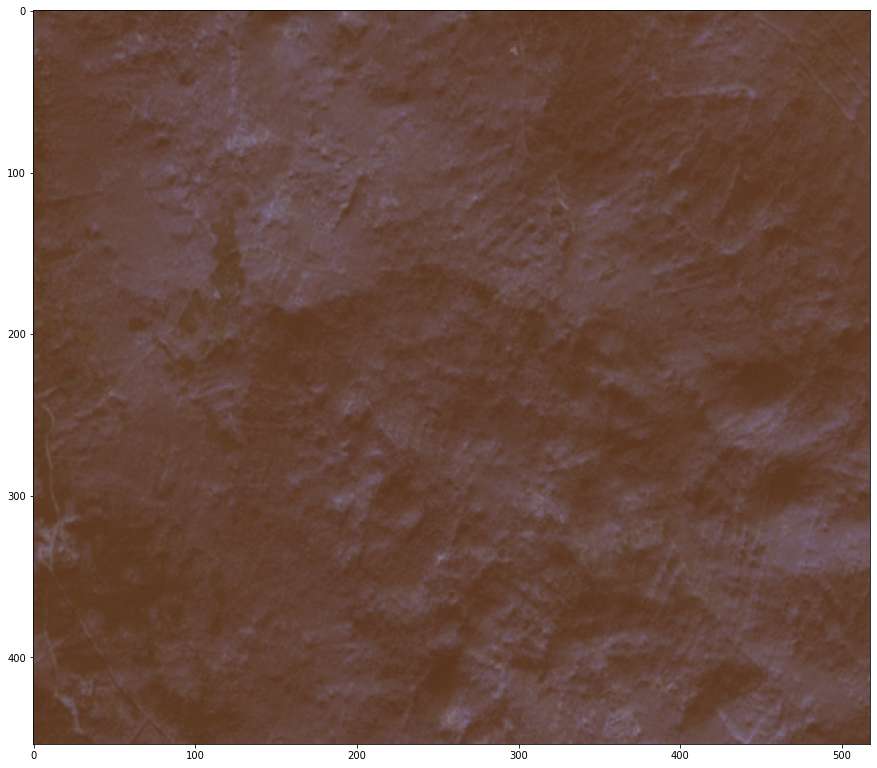

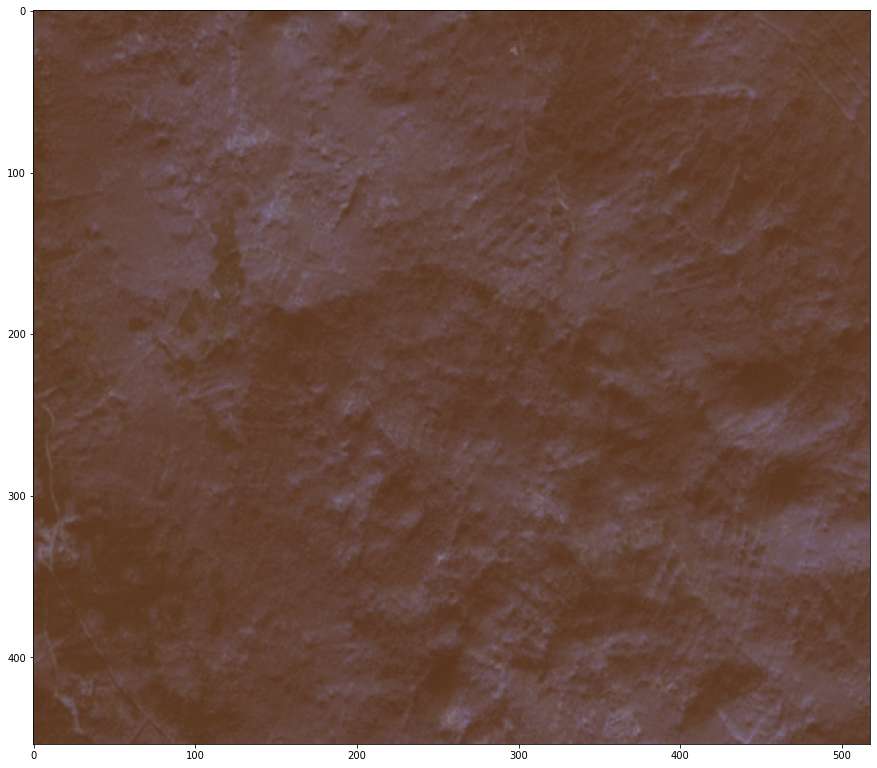

In [52]:
date = ('2015-04-01', '2015-12-31')
bbox = BBox([15.090611141776641,45.47426252844273, 
15.1570440946575,45.51505455284814], crs=CRS.WGS84)
config = is_config()

request_all_bands = get_all_bands_data(date,bbox,config)
all_bands_response = request_all_bands.get_data()
plot_image(all_bands_response[0][:, :, 1:4], factor=3.5 / 1e4, vmax=1)

In [65]:
def get_band_b8(request_all_bands):
  return request_all_bands.get_data()[0][:,:,7]

def get_band_b4(request_all_bands):
  return request_all_bands.get_data()[0][:,:,3]

def get_band_b3(request_all_bands):
  return request_all_bands.get_data()[0][:,:,2]

def get_band_b11(request_all_bands):
  return request_all_bands.get_data()[0][:,:,10]

band_b11 = get_band_b11(request_all_bands)
band_b8 = get_band_b8(request_all_bands)
band_b4 = get_band_b4(request_all_bands)
band_b3 = get_band_b3(request_all_bands)
print(band_b11)
print(band_b8)
print(band_b4)
print(band_b3)


#        B8 - B4
# NDVI = -------
#        B8 + B4
def get_ndvi(band_b8,band_b4):
  print("NORMALISED VEGETATION INDEX")
  numerator_ndvi = np.subtract(band_b8,band_b4)
  denominator_ndvi = np.add(band_b8,band_b4)
  ndvi_result = np.divide(numerator_ndvi,denominator_ndvi)
  with np.printoptions(threshold=np.inf):
    print('Band 8')
    print("Maximum value: {}".format(np.amax(band_b8)))
    print("Minimum value: {}".format(np.amin(band_b8)))
    print('Band 4')
    print("Maximum value: {}".format(np.amax(band_b4)))
    print("Minimum value: {}".format(np.amin(band_b4)))
    print('Numerator')
    print("Maximum value: {}".format(np.amax(numerator_ndvi)))
    print("Minimum value: {}".format(np.amin(numerator_ndvi)))
    print('Deominator')
    print("Maximum value: {}".format(np.amax(denominator_ndvi)))
    print("Minimum value: {}".format(np.amin(denominator_ndvi)))
    print('NDVI')
    print("Maximum value: {}".format(np.amax(ndvi_result)))
    print("Minimum value: {}".format(np.amin(ndvi_result)))
  return ndvi_result

ndvi_result = get_ndvi(band_b8,band_b4)


#        B4
#  RGI = --
#        B3
def get_rgi(band_b4,band_b3):
  print('REG GREEN INDEEX')
  rgi_result = np.divide(band_b4,band_b3)
  with np.printoptions(threshold=np.inf):
      print(rgi_result.shape)
      print("Maximum value: {}".format(np.amax(rgi_result)))
      print("Minimum value: {}".format(np.amin(rgi_result)))
  return rgi_result
rgi_result = get_rgi(band_b4,band_b3)


#        B11 - B8
# NBUI = --------
#        B11 + B8
def get_nbui(band_b11,band_b8):
  print('NORMALISED BUILD UP INDEX')
  numerator_nbui = band_b11 - band_b8
  denominator_nbui = band_b11 + band_b8
  nbui_result = np.divide(numerator_nbui,denominator_nbui)
  return nbui_result
nbui_result = get_nbui(band_b11,band_b8)

[[15 15 15 ... 18 18 18]
 [15 15 15 ... 18 18 18]
 [15 15 15 ... 18 18 18]
 ...
 [ 8  8  8 ... 13 13 13]
 [ 8  8  8 ... 13 13 13]
 [ 8  8  8 ... 13 13 13]]
[[1272 1218 1094 ...  887  889  993]
 [1299 1084  933 ...  790  908 1088]
 [1331 1221 1131 ...  642  771  934]
 ...
 [ 933 1050 1228 ...  631  607  468]
 [1330 1250  982 ...  624  545  420]
 [1193 1100 1170 ...  535  464  425]]
[[706 670 622 ... 508 472 491]
 [702 609 548 ... 459 459 479]
 [706 628 562 ... 458 459 469]
 ...
 [401 417 449 ... 469 448 383]
 [452 453 439 ... 454 429 389]
 [518 490 434 ... 410 386 399]]
[[816 796 762 ... 699 696 736]
 [784 754 739 ... 676 699 708]
 [824 790 747 ... 671 683 679]
 ...
 [656 668 693 ... 685 663 619]
 [707 693 670 ... 668 629 625]
 [749 703 675 ... 643 619 634]]
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 3569
Minimum value: 243
Band 4
Maximum value: 1668
Minimum value: 330
Numerator
Maximum value: 65535
Minimum value: 0
Deominator
Maximum value: 4991
Minimum value: 590
NDVI
Maximum v

# Normalised Difference Vegetation Index

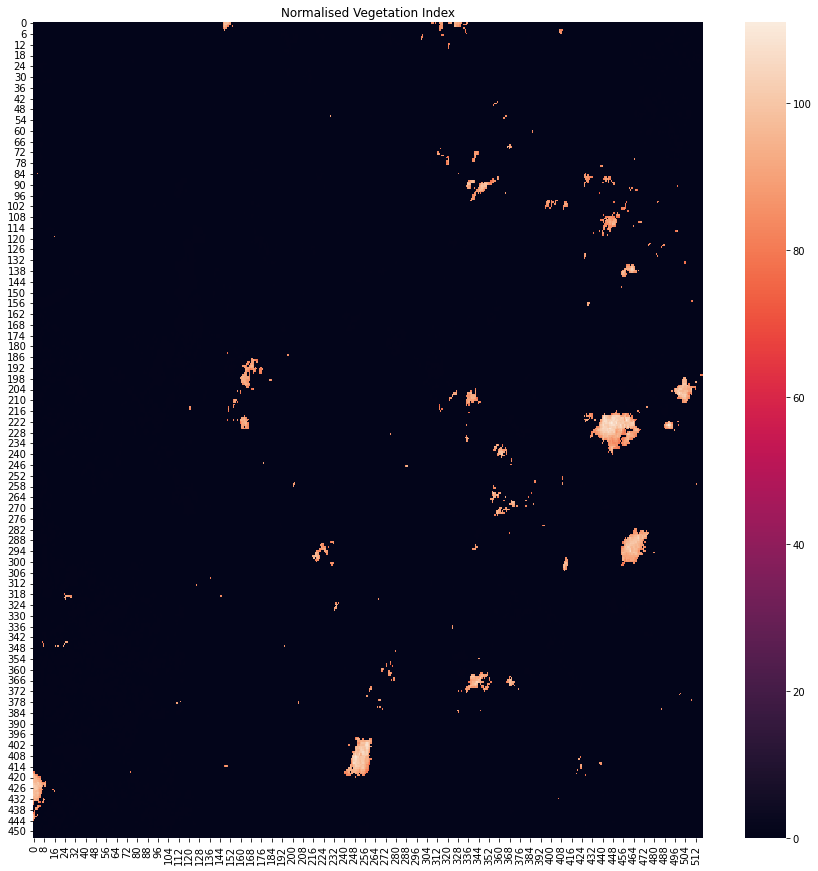

[[0.28614762 0.29025424 0.27505828 ... 0.27168459 0.30639236 0.33827493]
 [0.29835082 0.28056704 0.25995949 ... 0.26501201 0.32845647 0.38864071]
 [0.30682376 0.3207139  0.33608978 ... 0.16727273 0.25365854 0.33143264]
 ...
 [0.3988006  0.43149284 0.46451998 ... 0.14727273 0.1507109  0.09988249]
 [0.49270483 0.46799765 0.38212526 ... 0.15769944 0.11909651 0.03831891]
 [0.39450614 0.3836478  0.45885287 ... 0.13227513 0.09176471 0.0315534 ]]
<class 'numpy.ndarray'>


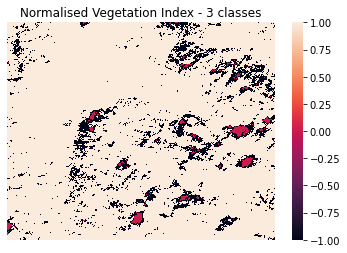

In [54]:
# NDVI - Classification

plot_ndvi(ndvi_result)
print(ndvi_result)
print(type(ndvi_result))

def ndvi_classification(ndvi_result):
  """
    Seperating the data intoo three groups: 
          1) < 0.2            => bare soil and man-made construction
          2) 0.2 <= x < 0.7   => sparse and unhealthy vegetation
          3) 0.7 <= x         => healthy vegetation
  """
  np_arr_ndvi_X = np.copy(ndvi_result)

  np_arr_ndvi_X[np_arr_ndvi_X < 0.2] = -1
  np_arr_ndvi_X[np_arr_ndvi_X > 0.7] = 0
  np_arr_ndvi_X[np_arr_ndvi_X > 0] = 1

  # show image:
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(np_arr_ndvi_X)
  plt.title("Normalised Vegetation Index - 3 classes",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("NDVI_2.png", bbox_inches='tight', dpi=100)
  # files.download("NDVI_2.png")
  plt.show()
  return np_arr_ndvi_X

np_arr_ndvi_X = ndvi_classification(ndvi_result)

# Red Green Index

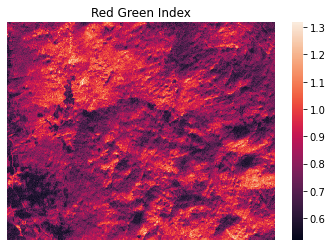

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


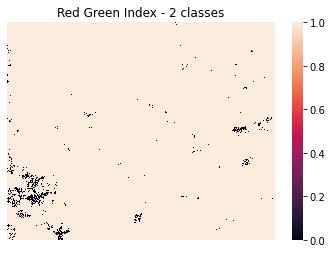

In [55]:
def rgi_classification(rgi_result):

  # Visualising RGI
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(rgi_result)
  plt.title("Red Green Index",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("RGI_2.png", bbox_inches='tight', dpi=100)
  # files.download("RGI_2.png")
  plt.show()

  """
    Seperating the data intoo three groups: 
          1) < 0.3      => unhealthy
          2) 0.7 <=     => healthy
  """
  np_arr_rgi_X = np.copy(rgi_result)

  print(type(np_arr_ndvi_X))
  np_arr_rgi_X[np_arr_rgi_X >= 0.6] = 1
  np_arr_rgi_X[np_arr_rgi_X < 0.60] = 0
  print(type(np_arr_ndvi_X))

  # show image:
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(np_arr_rgi_X)
  plt.title("Red Green Index - 2 classes",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("NDVI_binary_2.png", bbox_inches='tight', dpi=100)
  # files.download("NDVI_binary_2.png")
  plt.show()
  return np_arr_rgi_X

np_arr_rgi_X = rgi_classification(rgi_result)

In [56]:
# RGI ++ NDVI

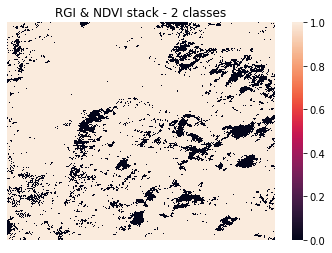

NDVI:
[[0.28614762 0.29025424 0.27505828 ... 0.27168459 0.30639236 0.33827493]
 [0.29835082 0.28056704 0.25995949 ... 0.26501201 0.32845647 0.38864071]
 [0.30682376 0.3207139  0.33608978 ... 0.16727273 0.25365854 0.33143264]
 ...
 [0.3988006  0.43149284 0.46451998 ... 0.14727273 0.1507109  0.09988249]
 [0.49270483 0.46799765 0.38212526 ... 0.15769944 0.11909651 0.03831891]
 [0.39450614 0.3836478  0.45885287 ... 0.13227513 0.09176471 0.0315534 ]]
RGI:
[[0.86519608 0.84170854 0.81627297 ... 0.7267525  0.67816092 0.66711957]
 [0.89540816 0.80769231 0.74154263 ... 0.67899408 0.65665236 0.67655367]
 [0.85679612 0.79493671 0.7523427  ... 0.68256334 0.67203514 0.69072165]
 ...
 [0.61128049 0.6242515  0.64790765 ... 0.68467153 0.67571644 0.6187399 ]
 [0.63932107 0.65367965 0.65522388 ... 0.67964072 0.68203498 0.6224    ]
 [0.69158879 0.6970128  0.64296296 ... 0.63763608 0.62358643 0.62933754]]
Stack:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ...

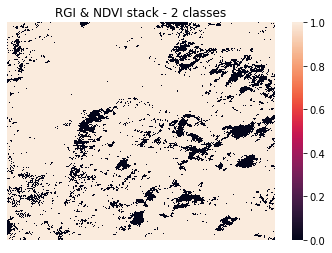

In [57]:
# Task 3: Stacking one matrix on top of the other

def combinator(np_arr_ndvi_X,np_arr_rgi_X):
  # np_arr_rgi_X = np.copy(rgi_result)
  # np_arr_ndvi_X = np.copy(ndvi_result)
  arr_result = np.copy(np_arr_ndvi_X)
  for i in range(np_arr_ndvi_X.shape[0]):
    for j in range(np_arr_ndvi_X.shape[1]):
      if np_arr_ndvi_X[i][j] == 1 and np_arr_rgi_X[i][j] == 1:
        arr_result[i][j] = 1
      else:
        arr_result[i][j] = 0


  # show image:
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(arr_result)
  plt.title("RGI & NDVI stack - 2 classes",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("NDVI_RGI_binary_2.png", bbox_inches='tight', dpi=100)
  # files.download("NDVI_RGI_binary_2.png")
  plt.show()
  return arr_result

# arr_result = np.copy(np_arr_ndvi_X)
# for i in range(np_arr_ndvi_X.shape[0]):
#   for j in range(np_arr_ndvi_X.shape[1]):
#     if np_arr_ndvi_X[i][j] == 1 and np_arr_rgi_X[i][j] == 1:
#       arr_result[i][j] = 1
#     else:
#       arr_result[i][j] = 0

arr_result = combinator(np_arr_ndvi_X,np_arr_rgi_X)

print('NDVI:')
print(ndvi_result)
print('RGI:')
print(rgi_result)
print('Stack:')
print(arr_result)

# show image:
sns.diverging_palette(60, 160, as_cmap=True)
ax = sns.heatmap(arr_result)
plt.title("RGI & NDVI stack - 2 classes",fontsize=12)
plt.xticks([])
plt.yticks([])
plt.savefig("NDVI_RGI_binary_2.png", bbox_inches='tight', dpi=100)
# files.download("NDVI_RGI_binary_2.png")
plt.show()

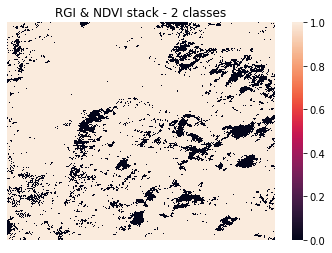

In [58]:
arr_result = np.copy(np_arr_ndvi_X)
for i in range(np_arr_ndvi_X.shape[0]):
  for j in range(np_arr_ndvi_X.shape[1]):
    if np_arr_ndvi_X[i][j] == 1 and np_arr_rgi_X[i][j] == 1:
      arr_result[i][j] = 1
    else:
      arr_result[i][j] = 0

# show image:
sns.diverging_palette(60, 160, as_cmap=True)
ax = sns.heatmap(arr_result)
plt.title("RGI & NDVI stack - 2 classes",fontsize=12)
plt.xticks([])
plt.yticks([])
plt.savefig("NDVI_RGI_binary_2.png", bbox_inches='tight', dpi=100)
# files.download("NDVI_RGI_binary_2.png")
plt.show()

In [59]:
def count_pixels(arr_result):
  num_white_pixels = (arr_result == 1).sum()
  print(f'Number of white pixels: {num_white_pixels}')
  print(f'Total number of pixels: {arr_result.shape[0]*arr_result.shape[1]}')
  print(arr_result.shape)
  percentage = num_white_pixels / (arr_result.shape[0] * arr_result.shape[1])
  print(f'Percentage of white pixels: {percentage}')

count_pixels(arr_result)

Number of white pixels: 205702
Total number of pixels: 235172
(454, 518)
Percentage of white pixels: 0.8746874627931897


In [60]:
def controller(bbox:BBox,date:str):
  config = is_config()
  true_color_image = get_RGB_bands_data(date,bbox,config)
  all_bands_response = get_all_bands_data(date,bbox,config=config)

# get_RGB_bands_data(date:str,bbox:BBox,cofing)
  #bands
  band_b8 = get_band_b8(all_bands_response)
  band_b4 = get_band_b4(all_bands_response)
  band_b3 = get_band_b3(all_bands_response)
  band_b11 = get_band_b11(all_bands_response)

  #NDVI
  ndvi_result = get_ndvi(band_b8,band_b4)
  np_arr_ndvi_X = ndvi_classification(ndvi_result)

  #RGI
  rgi_result = get_rgi(band_b4, band_b3)
  np_arr_rgi_X = rgi_classification(rgi_result)

  # arr_result = combined_classification(np_arr_ndvi_X,np_arr_rgi_X)
  arr_result = combinator(np_arr_ndvi_X,np_arr_rgi_X)

  count_pixels(arr_result)

# controller(bbox,'2017-08-24')

# Here all the methods are called!

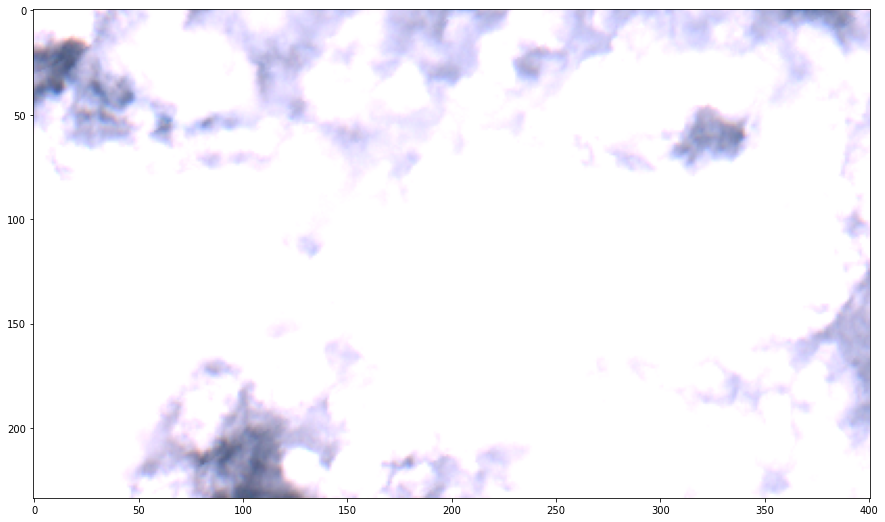

In [154]:
date = ('2020-01-01','2020-12-31')
bbox = BBox([14.231442824859885,45.77008157282224,
14.28276957656887,45.791511016125], crs=CRS.WGS84)
config = is_config()
true_color_image = get_RGB_bands_data(date,bbox,config)
plot_image(true_color_image)

NORMALISED VEGETATION INDEX
(138, 258)
Maximum value: 0.855250886028726
Minimum value: 0.2511563367252544


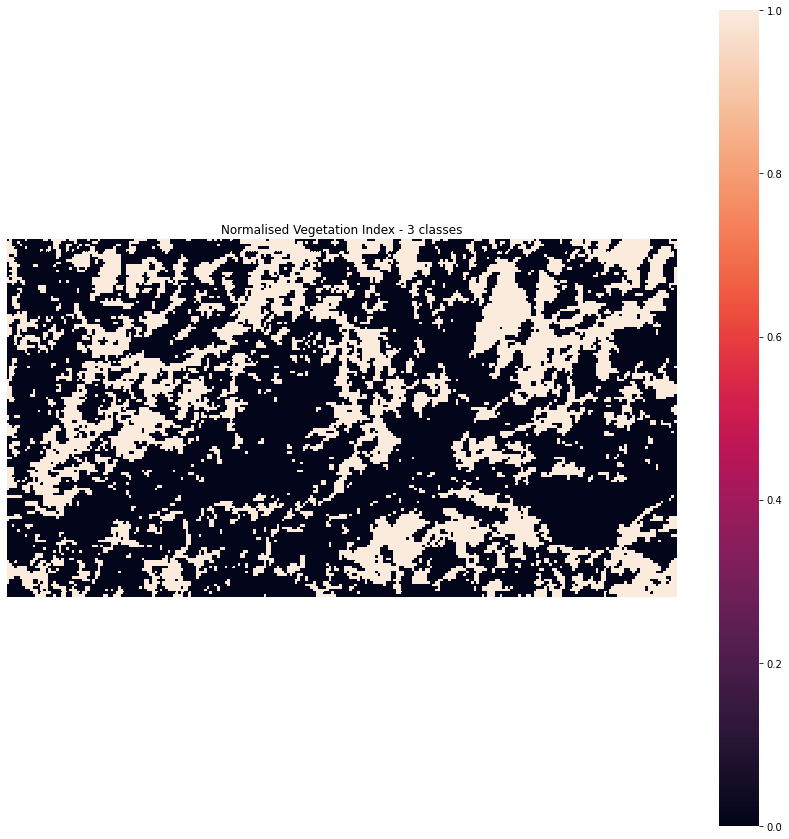

REG GREEN INDEEX
(138, 258)
Maximum value: 1.1809903244166193
Minimum value: 0.4463276836158192


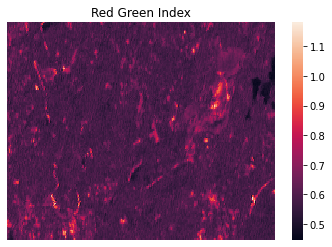

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


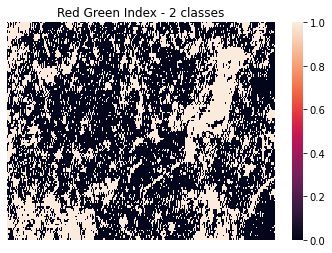

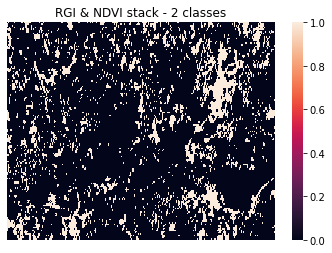

Number of white pixels: 6043
Total number of pixels: 35604
(138, 258)
Percentage of white pixels: 0.16972812043590607


In [121]:
# region of interes
bbox = BBox([14.04038597356616,46.35774675361819,
14.073688280695066,46.37048108289878], crs=CRS.WGS84)
date = ('2015-01-01','2015-12-31')

controller(bbox,date)

-------------------
-------------------
2015
-------------------
-------------------
NORMALISED VEGETATION INDEX
(212, 243)
Maximum value: 17.184155299055615
Minimum value: 0.00041407867494824016


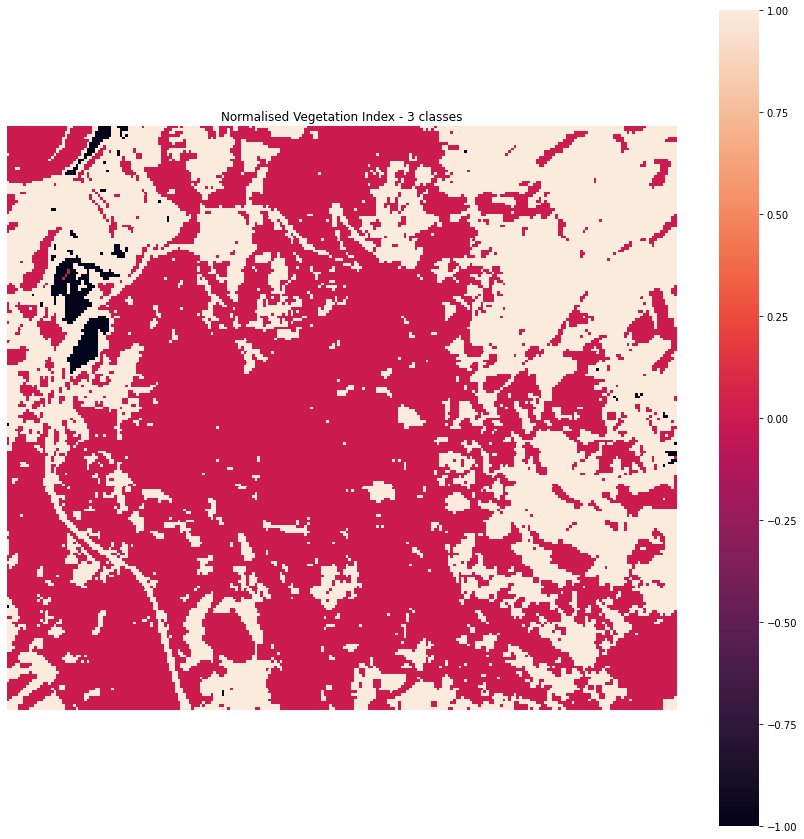

REG GREEN INDEEX
(212, 243)
Maximum value: 1.7219730941704037
Minimum value: 0.47162162162162163


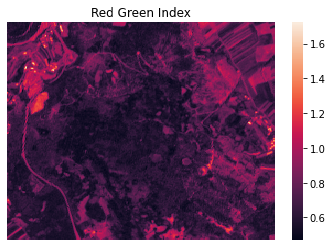

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


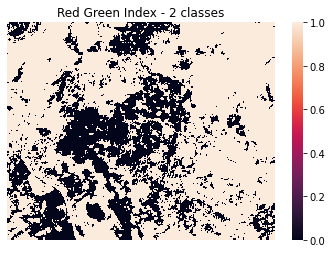

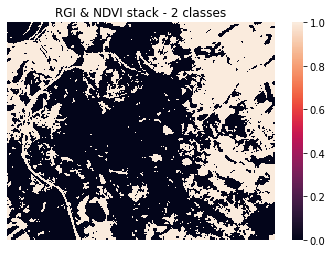

Number of white pixels: 20369
Total number of pixels: 51516
(212, 243)
Percentage of white pixels: 0.39539172295985714
-------------------
-------------------
2016
-------------------
-------------------
NORMALISED VEGETATION INDEX
(212, 243)
Maximum value: 18.234409799554566
Minimum value: 0.0


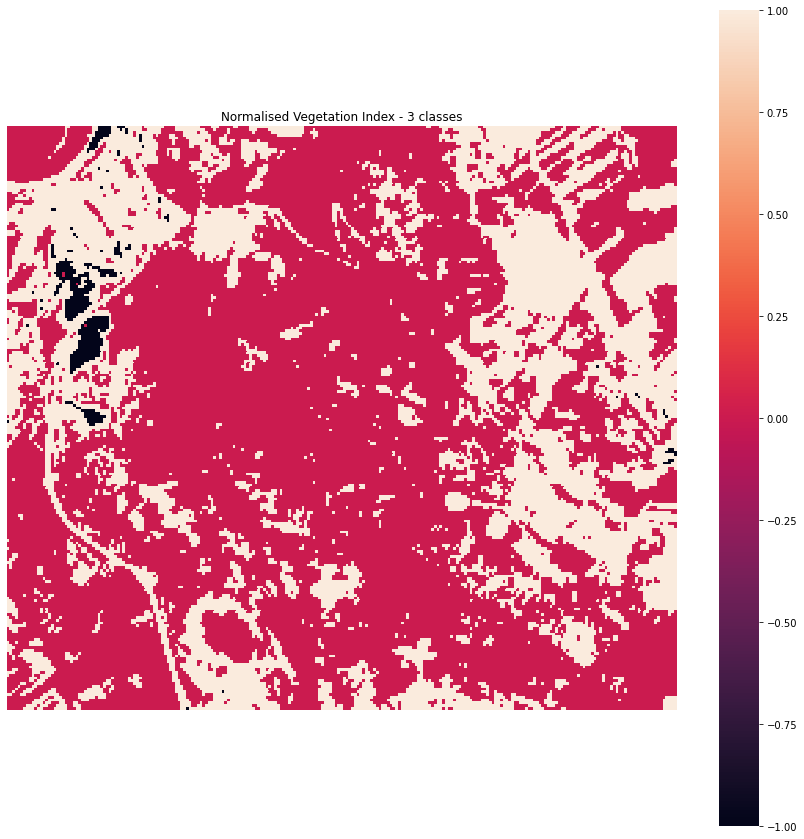

REG GREEN INDEEX
(212, 243)
Maximum value: 1.6751412429378532
Minimum value: 0.44711538461538464


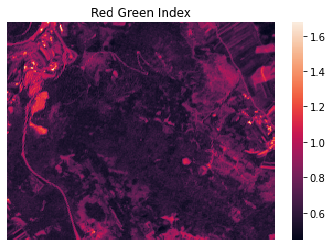

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


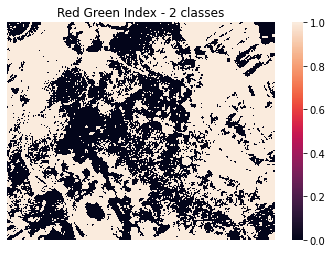

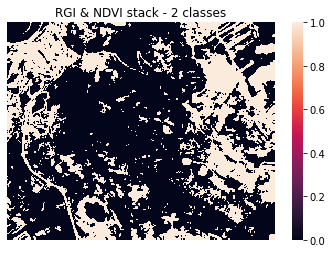

Number of white pixels: 16967
Total number of pixels: 51516
(212, 243)
Percentage of white pixels: 0.32935398711080055
-------------------
-------------------
2017
-------------------
-------------------
NORMALISED VEGETATION INDEX
(212, 243)
Maximum value: 0.8217071540004457
Minimum value: 0.025564803804994055


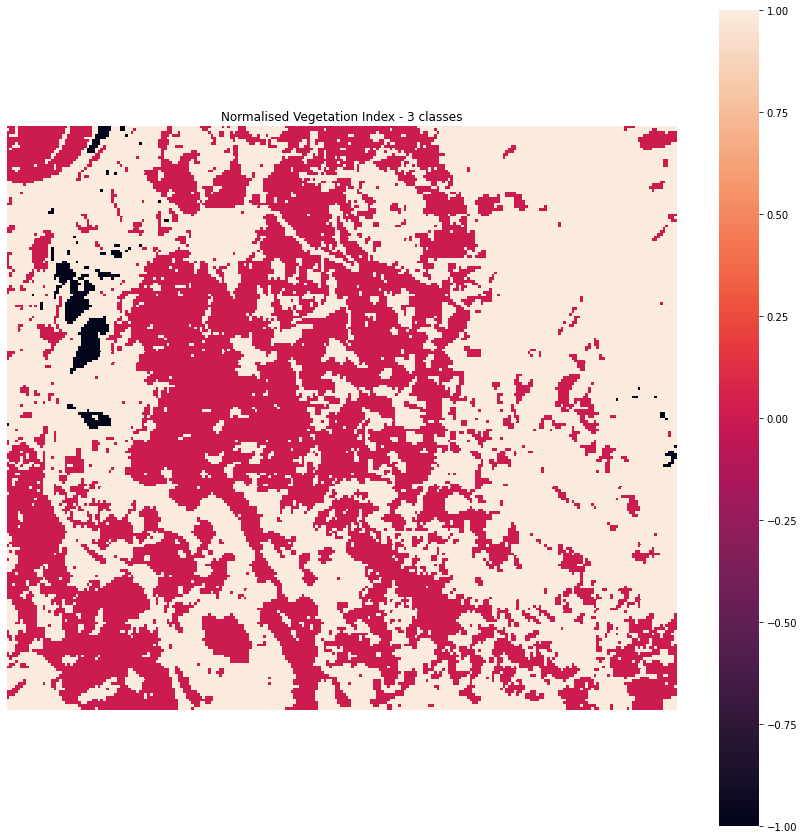

REG GREEN INDEEX
(212, 243)
Maximum value: 1.770566727605119
Minimum value: 0.52023988005997


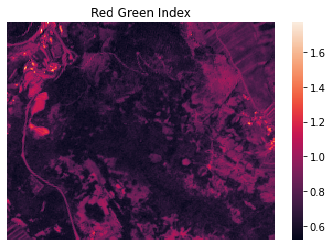

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


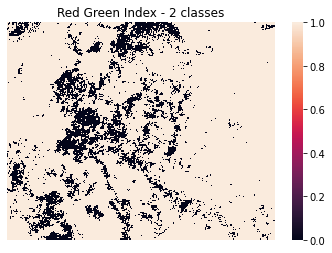

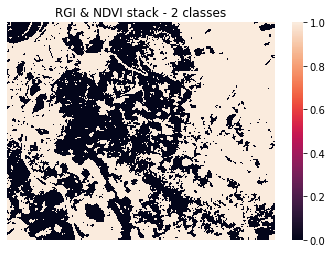

Number of white pixels: 30447
Total number of pixels: 51516
(212, 243)
Percentage of white pixels: 0.5910202655485675
-------------------
-------------------
2018
-------------------
-------------------
NORMALISED VEGETATION INDEX
(212, 243)
Maximum value: 0.8703861200884504
Minimum value: 0.008674101610904586


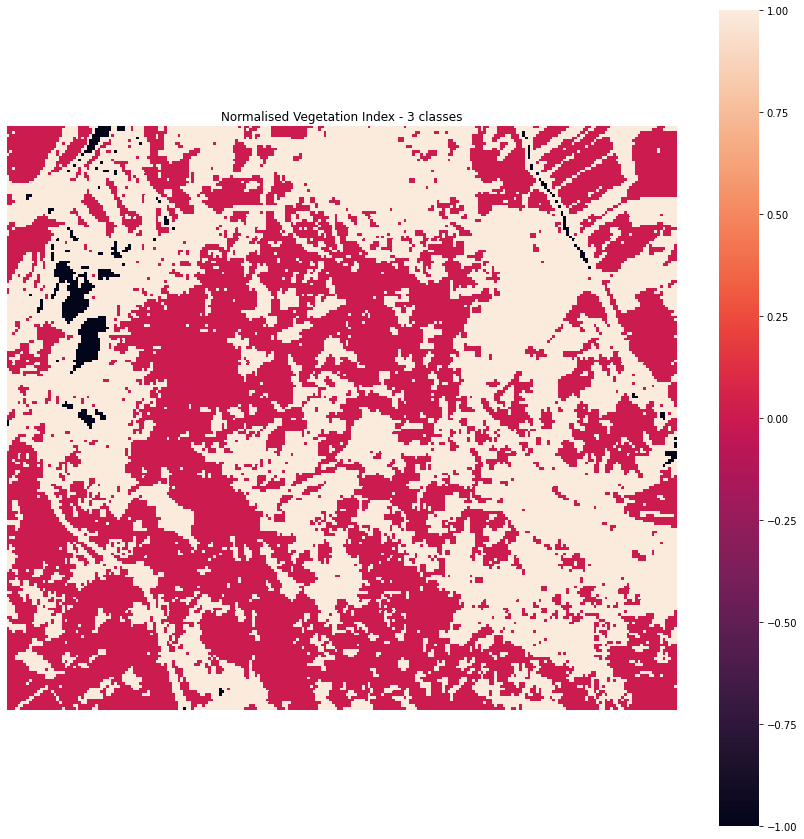

REG GREEN INDEEX
(212, 243)
Maximum value: 1.7036059806508355
Minimum value: 0.4337485843714609


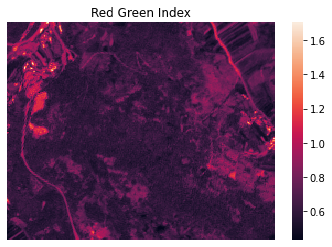

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


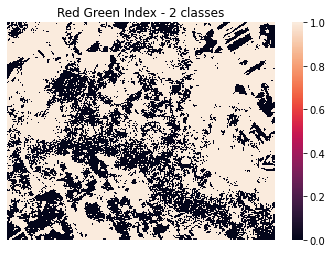

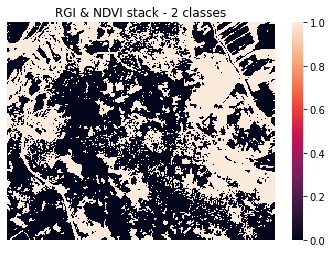

Number of white pixels: 22212
Total number of pixels: 51516
(212, 243)
Percentage of white pixels: 0.43116701607267643
-------------------
-------------------
2019
-------------------
-------------------
NORMALISED VEGETATION INDEX
(212, 243)
Maximum value: 0.8587842846553002
Minimum value: 0.01765177855041455


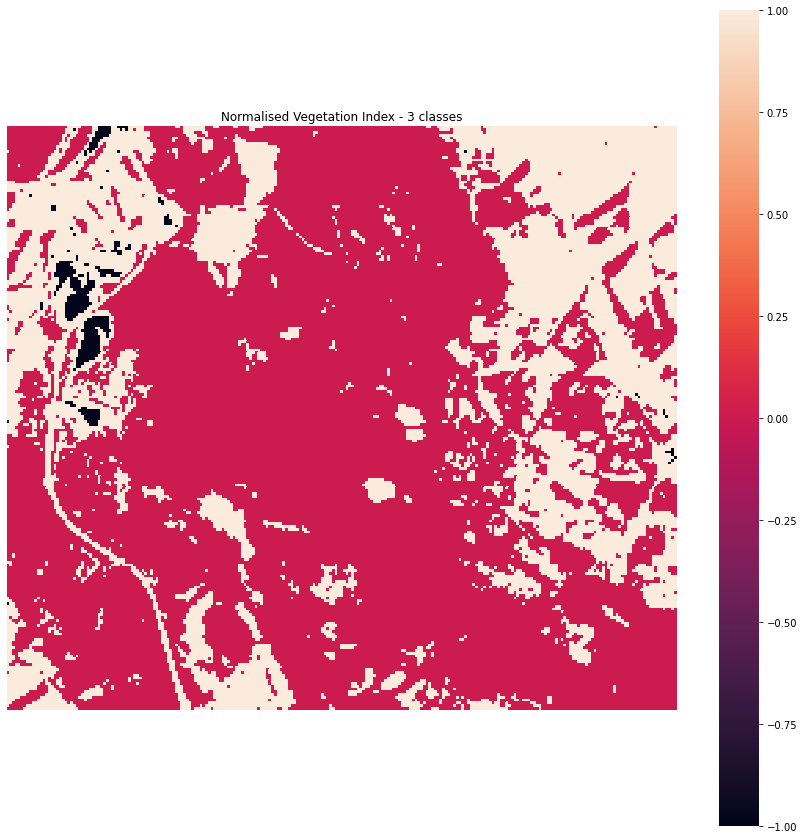

REG GREEN INDEEX
(212, 243)
Maximum value: 1.7119341563786008
Minimum value: 0.4609164420485175


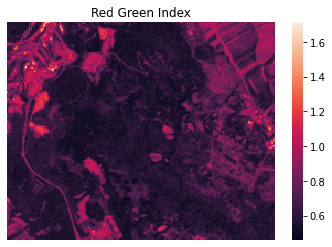

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


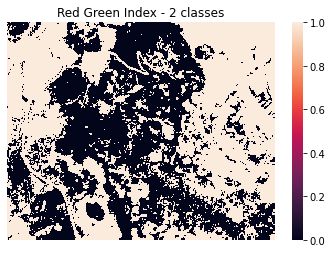

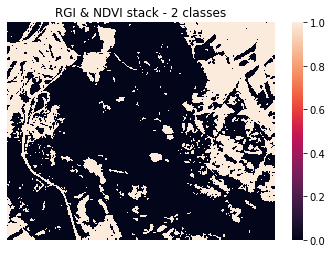

Number of white pixels: 15736
Total number of pixels: 51516
(212, 243)
Percentage of white pixels: 0.3054584983306157
-------------------
-------------------
2020
-------------------
-------------------
NORMALISED VEGETATION INDEX
(212, 243)
Maximum value: 0.865635025476505
Minimum value: 0.01440809968847352


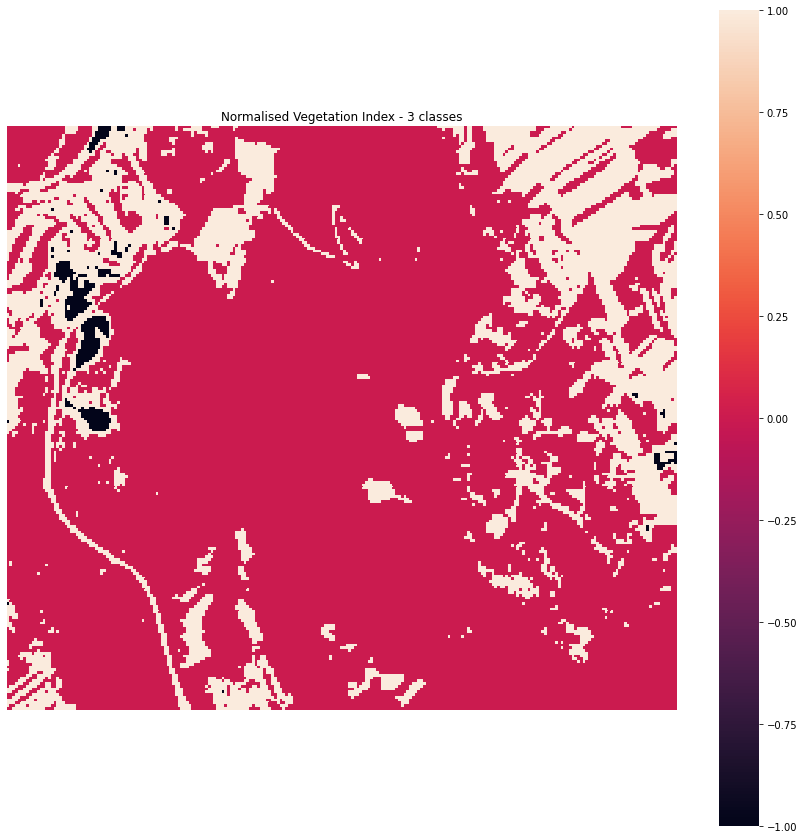

REG GREEN INDEEX
(212, 243)
Maximum value: 1.8280967858432646
Minimum value: 0.44344904815229563


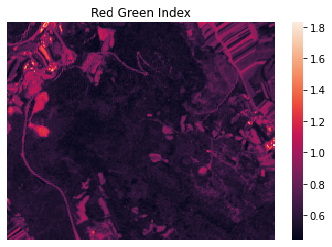

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


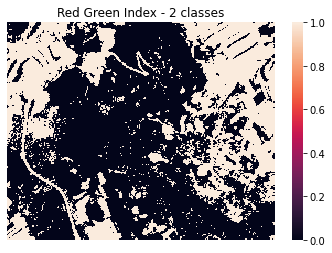

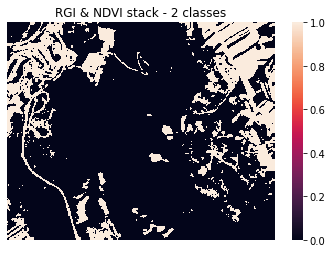

Number of white pixels: 11034
Total number of pixels: 51516
(212, 243)
Percentage of white pixels: 0.21418588399720476


In [168]:
# automating all of it
# region of interes
bbox = BBox([14.185421480589552,45.653946875489495,
14.216320528441114,45.67326187565938
], crs=CRS.WGS84)

for i in range(2015,2021):
  print('-------------------')
  print('-------------------')
  print(i)
  print('-------------------')
  print('-------------------')
  year_start = str(i)+'-01-01'
  year_end   = str(i)+'-12-31'
  date = (year_start,year_end)
  controller(bbox,date)